In [2]:
import pandas as pd
import numpy as np  
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
# Data cleansing v1
'''
id : 단순 id
url : 단순 url
title : purpose 칼럼에서 더 categorized 설명되는 내용
application_type : individual이 980개
next_pymnt_d : 칼럼이 비어 있음
policy_code : 값이 모두 1임
chargeoff_within_12_mths : 0이 995개
delinq_amnt : 0이 997개
num_tl_120dpd_2m : 0이 아닌 값이 딱 1개
num_tl_30dpd : 0이 아닌 값이 딱 2개
hardship_flag : 값이 모두 N
disbursement_method : cash가 997개
'''

df = pd.read_csv("lending_club_sample.csv")
df = df.drop(columns=["id",
                      "url",
                      "title",
                      "application_type",
                      "next_pymnt_d",
                      "policy_code",
                      "chargeoff_within_12_mths",
                      "delinq_amnt",
                      "num_tl_120dpd_2m",
                      "num_tl_30dpd",
                      "hardship_flag",
                      "disbursement_method"])

df.to_csv("data_preprocessed_v1.csv", index=False)

In [28]:
# Data cleansing v3
df = pd.read_csv("./data_preprocessed_v1.csv")

# grade, sub_grade
# categorical variable(ordinal variable) Labeling
og_grade = df["grade"]
og_sub_grade = df["sub_grade"]

grade = np.array(df["grade"])
sub_grade = np.array(df["sub_grade"])

encoder = LabelEncoder()
grade_encoded = encoder.fit_transform(grade)
sub_grade_encoded = encoder.fit_transform(sub_grade)

df["grade"] = grade_encoded
df["sub_grade"] = sub_grade_encoded

# data cleansing. drop columns which has under 50 datas
df = df.loc[:, df.count() >= 50]

# fico_range_low
# data cleansing. add avg fico score column 
insert_loc = df.columns.get_loc('fico_range_low')
df.insert(insert_loc, 'fico_avg', (df['fico_range_low'] + df['fico_range_high']) / 2)

# emp_length
# 2 way of emp_length mapping.
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 0~10
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 1~11. 무직과 고용상태를 구분하기 위함
label_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length'] = df['emp_length'].map(label_mapping)
df['emp_length'] = df['emp_length'].fillna(-1)

# term
# categorical variable Labeling
label_mapping = {
    ' 36 months': 36,
    ' 60 months': 60
}

df['term'] = df['term'].map(label_mapping)

# mths_since_last_delinq
# 최종 연체 후 경과 개월 수
# 연체가 있었는지 없었는지 binary로 구분하는 데이터로 사용하면 될듯
# 연체가 없었으면 0, 있었으면 1
insert_loc = df.columns.get_loc('mths_since_last_delinq')
df.insert(insert_loc, 'delinq_flag', np.where(df['mths_since_last_delinq'].isna(), 0, 1))

# mths_since_last_record
# 마지막 파산 기록 이후 경과된 개월 수
# 이거 유용한 정보인거 같긴 한데, 한국어 번역에 문제가 있는 것같다. 영어 원문에 public record라고 써있는데, public record는 파산을 포함한 공적 기록을 의미한다. 따라서 꼭 파산이 아닐 수도 있음.
# https://credit.org/blogs/blog-posts/understanding-your-public-record-information 해당 링크에 따르면, 판결 등의 정보도 public record에 포함된다.
# 일단 drop

# revol_util
# follow paper (Machine learning and artificial neural networks to construct P2P lending credit-scoring model: A case using Lending Club data), form change percentage form to decimal form
# 결측치는 평균값으로 채워넣는다
df['revol_util'] = df['revol_util'] / 100.0
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

# tot_coll_amt
# 총 채권 추심 금액
# 결측값만 처리
df["tot_coll_amt"] = df["tot_coll_amt"].fillna(0)

# tot_cur_bal
# 모든 계좌 현재 잔액 합계
# 결측값은 중앙값으로
df["tot_cur_bal"] = df["tot_cur_bal"].fillna(df["tot_cur_bal"].median())

# total_rev_hi_lim
# 리볼빙 총 한도
# 결측값은 중앙값으로
df["total_rev_hi_lim"] = df["total_rev_hi_lim"].fillna(df["total_rev_hi_lim"].median())

# acc_open_past_24mths
# 최근 24개월 동안 개설된 신용거래 건수
# 결측값은 중앙값으로
df["acc_open_past_24mths"] = df["acc_open_past_24mths"].fillna(df["acc_open_past_24mths"].median())

# avg_cur_bal
# 모든 계좌의 평균 현재 잔액
# 결측값은 중앙값으로
df["avg_cur_bal"] = df["avg_cur_bal"].fillna(df["avg_cur_bal"].median())

# bc_open_to_buy
# 리볼빙 은행카드 사용 가능 한도
# 결측값은 중앙값으로
df["bc_open_to_buy"] = df["bc_open_to_buy"].fillna(df["bc_open_to_buy"].median())

# bc_util
# 은행카드 한도 대비 잔액 비율
# 결측값은 평균값으로
df['bc_util'] = df['bc_util'] / 100.0
df['bc_util'] = df['bc_util'].fillna(df['bc_util'].mean())

# mort_acc
# 주택담보대출 계좌 수
# 결측값은 중앙값으로
df["mort_acc"] = df["mort_acc"].fillna(df["mort_acc"].median())

# num_accts_ever_120_pd
# 120일 이상 연체 경험 계좌 수
# 결측값은 중앙값으로
df["num_accts_ever_120_pd"] = df["num_accts_ever_120_pd"].fillna(df["num_accts_ever_120_pd"].median())

# num_actv_bc_tl
# num_actv_rev_tl
# num_bc_sats
# num_bc_tl
# num_il_tl
# num_op_rev_tl
# num_rev_accts
# num_rev_tl_bal_gt_0
# num_sats
# 다 현재 계좌 수에 관련된 칼럼. 나중에 보고 좀 합쳐야할듯
# 결측값은 중앙값으로
cols = [
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'num_bc_tl',
    'num_il_tl',
    'num_op_rev_tl',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'num_sats'
]

df[cols] = df[cols].fillna(df[cols].median())

# num_tl_90g_dpd_24m : 최근 24개월 90일 이상 연체 계좌 수
# num_tl_op_past_12m : 최근 12개월 개설 계좌 수
# tot_hi_cred_lim : 총 최고 신용 한도
# total_bal_ex_mort : 주택담보 제외 총 잔액
# total_bc_limit : 은행카드 총 한도
# total_il_high_credit_limit : 할부 계좌 총 한도
# 결측값은 중앙값으로
cols = [
    'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m',
    'tot_hi_cred_lim',
    'total_bal_ex_mort',
    'total_bc_limit',
    'total_il_high_credit_limit'
]

df[cols] = df[cols].fillna(df[cols].median())

# pct_tl_nvr_dlq : 연체 경험 없는 계좌 비율
# percent_bc_gt_75 : 한도 75% 초과 은행카드 계좌 비율
# 결측값은 평균으로
cols = ['pct_tl_nvr_dlq', 'percent_bc_gt_75']

df[cols] = df[cols].fillna(df[cols].mean())

# loan_status : 부도 여부, 타겟 변수
# non-default = 0, default = 1
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# drop columns
'''
모델링을 위해 필요없어보이는 칼럼을 삭제. 추후에 재검토를 통해 살려서 다시 쓸 수도 있음
zip_code : 알아보니 zip_code 앞 3자리로는 state + city까지 알 수 있던데, 일단 addr_state에서 state는 알 수 있으니 탈락
fico_range_low : fico_range_high와 평균내어 fico_avg라는 파생변수로 만듬
desc : 대출 이유 설명 칸인데, nlp로 사용할 여지가 있긴 하지만 비어있는 칼럼 비율이 너무 높음. 92.7%
emp_title : 직업이 labeling하기 힘들 정도로 다양하기도 하고 근속 연수와 소득이 더 직관적인 데이터라고 생각해서 탈락
mths_since_last_delinq : 연체 여부를 판단하는 binary type 파생변수로 만듬. delinq_falg
mths_since_last_record : 일단 drop, 위 사유 참조
last_pymnt_d : 변수가 뭘 의미하는지 모르겠어서 일단 드랍. 시계열 데이터와 연관 있는거라면, 모델 개입 시점 때문에 탈락
mths_since_last_major_derog : 90일 이상 연체 여부인데, 연체 여부랑 크게 다를거 같지 않아서 일단 탈락
mo_sin_old_il_acct : 가장 오래된 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의
mo_sin_old_rev_tl_op : 
mo_sin_rcnt_rev_tl_op : 
mo_sin_rcnt_tl : 
mths_since_recent_bc : 최근 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의 
mths_since_recent_bc_dlq : 
mths_since_recent_inq : 
mths_since_recent_revol_delinq : 
last_fico_range_high : 대출 신청 전 fico 점수가 따로 있음
last_fico_range_low : 
'''
df = df.drop(columns=["zip_code",
                      "fico_range_low",
                      "fico_range_high",
                      "desc",
                      "emp_title",
                      "mths_since_last_delinq",
                      "mths_since_last_record",
                      "last_pymnt_d",
                      "mths_since_last_major_derog",
                      "mo_sin_old_il_acct",
                      "mo_sin_old_rev_tl_op",
                      "mo_sin_rcnt_rev_tl_op",
                      "mo_sin_rcnt_tl",
                      "mths_since_recent_bc",
                      "mths_since_recent_bc_dlq",
                      "mths_since_recent_inq",
                      "mths_since_recent_revol_delinq",
                      "last_fico_range_high",
                      "last_fico_range_low"
                      ])

# 30% 이상 결측치를 가지는 칼럼 drop
df = df.loc[:, df.isnull().mean() < 0.3]

df.to_csv("./data_preprocessed_v3.csv", index=False)
df["loan_status"].value_counts()

loan_status
0    792
1    208
Name: count, dtype: int64

In [29]:
# View categorical columns

df.select_dtypes(include=['object', 'category']).columns.tolist()
df = df.drop(columns=df.select_dtypes(include=['object', 'category']).columns.tolist())
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,20000.0,20000.0,20000.0,36,13.99,683.46,2,12,10.0,65000.0,...,0.0,2.0,100.0,66.700000,0.0,0.0,759411.0,27732.0,17500.0,23245.0
1,7000.0,7000.0,7000.0,36,9.16,223.12,1,6,-1.0,35000.0,...,0.0,4.0,96.6,25.000000,0.0,0.0,53672.0,28344.0,19200.0,23072.0
2,20000.0,20000.0,20000.0,36,8.67,632.93,1,5,10.0,90000.0,...,0.0,1.0,89.7,57.100000,0.0,0.0,434045.0,47232.0,28300.0,32219.0
3,16000.0,16000.0,16000.0,36,14.46,550.43,2,13,5.0,50000.0,...,0.0,0.0,84.0,33.300000,0.0,0.0,155587.0,81483.0,77000.0,73587.0
4,4000.0,4000.0,4000.0,36,11.53,131.97,1,9,2.0,85000.0,...,0.0,2.0,73.7,46.724421,0.0,0.0,329177.0,91411.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,21000.0,21000.0,21000.0,60,25.82,626.52,4,23,2.0,125000.0,...,0.0,6.0,100.0,66.700000,0.0,0.0,377464.0,157456.0,12000.0,117101.0
996,10625.0,10625.0,10625.0,60,17.57,267.33,3,18,10.0,70000.0,...,0.0,5.0,100.0,0.000000,1.0,0.0,89666.0,70977.0,6000.0,77266.0
997,7000.0,7000.0,7000.0,36,8.18,219.94,1,5,3.0,50000.0,...,0.0,4.0,92.3,50.000000,0.0,0.0,71752.0,50074.0,10600.0,49652.0
998,8000.0,8000.0,8000.0,36,13.35,270.91,2,11,10.0,50550.0,...,0.0,2.0,100.0,81.800000,0.0,0.0,59391.0,42018.0,19300.0,27423.0


In [25]:
# Feture selection
# 모델 개입 시점에 따르면, 대출 실행 전 신용도를 LC입장에서 자체 신용등급평가를 하게 됨.
# 신용등급과 대출 실행의 부산물인 int_rate는 grade와 매우 연관 깊음. 따라서 탈락시킴
# 타겟변수가 grade인 경우, sub_grade인 경우 두 가지를 테스트함
# df1 = df.drop(columns=['int_rate', 'sub_grade'])
# # df2 = df.drop(columns=['int_rate', 'grade'])
# 
# df1["grade"].value_counts()
# # df2["sub_grade"].value_counts()
# 
# # grade의 e, f, g등급 데이터 개수가 너무 적어 e등금 이하로 통합
# df1.loc[df['grade'].isin([5, 6]), 'grade'] = 4
# df1["grade"].value_counts()

In [13]:
# CORR
# witout categorical columns

# corr_matrix = df.corr()

# plt.figure(figsize=(40, 30))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title("Correlation Matrix")
# plt.savefig("./correlation_matrix.jpg", dpi=600, bbox_inches='tight')
# plt.show()


Random Forest Feature Importances:
                       Feature  Importance
28     collection_recovery_fee    0.163234
27                  recoveries    0.160333
24             total_rec_prncp    0.122945
29             last_pymnt_amnt    0.080068
22                 total_pymnt    0.060456
23             total_pymnt_inv    0.050521
1                  funded_amnt    0.044962
2              funded_amnt_inv    0.036311
5                  installment    0.035655
0                    loan_amnt    0.032538
3                         term    0.016059
4                     int_rate    0.014512
25               total_rec_int    0.014298
7                    sub_grade    0.011400
38                     bc_util    0.008691
17                   revol_bal    0.007554
18                  revol_util    0.006835
6                        grade    0.006415
58              total_bc_limit    0.005923
9                   annual_inc    0.005862
33                 tot_cur_bal    0.005765
10                 

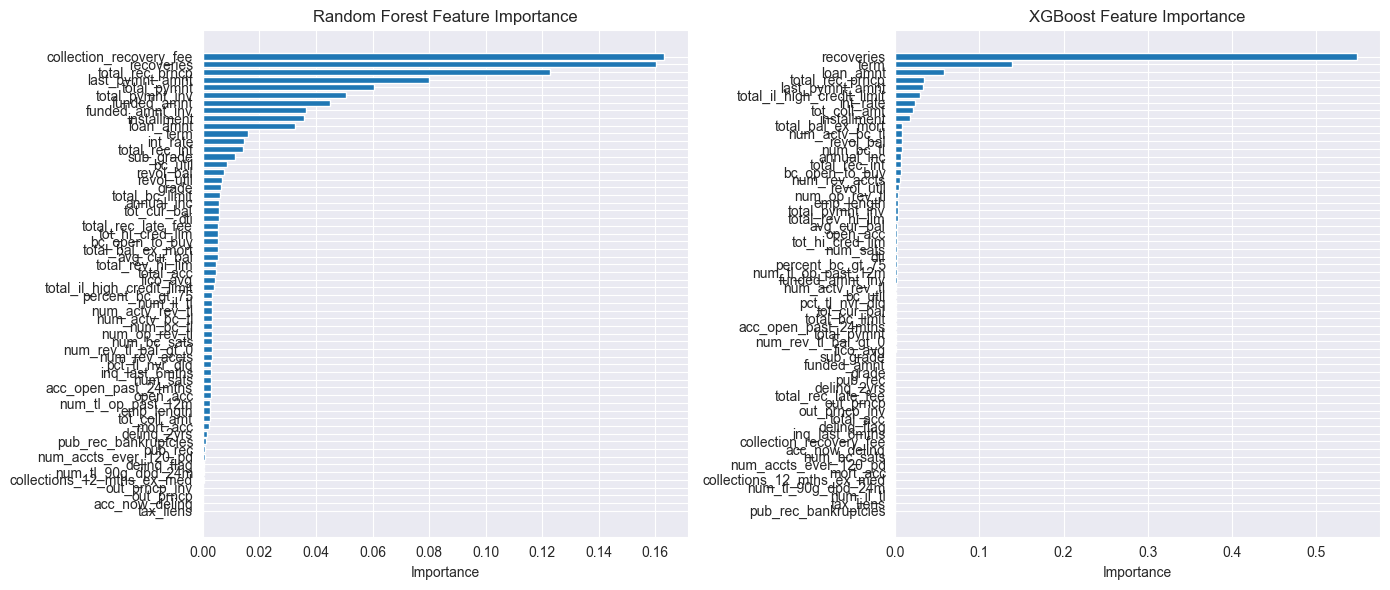

In [30]:
# 데이터 준비: df1 사용
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# --- Random Forest로 Feature Importance 추출 ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
rf_importances = rf.feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances:")
print(rf_importance_df)

# --- XGBoost로 Feature Importance 추출 ---
# use_label_encoder=False와 eval_metric 설정은 최신 XGBoost 버전에서 발생하는 경고를 피하기 위함입니다.
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb.fit(X, y)
xgb_importances = xgb.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importances:")
print(xgb_importance_df)

# --- 중요도가 높은 변수들 시각화 (각 모델 별) ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.gca().invert_yaxis()  # 가장 중요한 변수 위쪽에 오도록
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")

plt.subplot(1, 2, 2)
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")

plt.tight_layout()
plt.show()
